![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/dodkins/PythonProjects/stocks/options_testing/options_testing')

import os
from datetime import datetime 
import pandas as pd
import opstrat as op

/Users/dodkins/.conda/envs/stocks/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from qc_simulator import QuantBook, Resolution, OptionRight

Importting qc_sim


In [3]:
import quantconnect
# from strategies import measure_period_profit
# from strategies import add_expirations

In [5]:
quantconnect.__file__

'/Users/dodkins/PythonProjects/stocks/options_testing/options_testing/quantconnect.py'

In [9]:
qbw = quantconnect.QuantBookWrapper({'qb':QuantBook(),'Resolution':Resolution,'OptionRight':OptionRight})

In [10]:
from strategies import measure_period_profit, LegMeta, StrategyBase
import plots

In [11]:
def IC_sim(nbars=200, stop_loss=20, stop_gain=None):
    tsla = qbw.get_tsla(nbars)
    legs = [
        LegMeta(trans='sell', contract='call', strike_offset= 15, exp_offset= 0),
        LegMeta(trans='buy',  contract='call', strike_offset= 16, exp_offset= 0),
        LegMeta(trans='sell', contract='put', strike_offset= -15, exp_offset= 0),
        LegMeta(trans='buy',  contract='put', strike_offset= -16, exp_offset= 0),
    ]  
    strat = StrategyBase(qbw=qbw, legs=legs, stop_loss=stop_loss, stop_gain=stop_gain, force_strike_diff=True)
    ic = measure_period_profit(tsla,  
        strat,
        expiration='week',
        update_freq='candle', 
        combine_legs=True)
    plots.plot_candles_and_profit(ic, lines=[f'{l.name}_strike' for l in strat.legs])
    plots.plot_candles_and_profit(
        ic, lines=[f'{l.name}_strike' for l in strat.legs if 'sell' == l.trans], 
        metrics=['strategy_close', 'stop_loss', 'stop_gain']
    )
    return ic

In [38]:
ic = IC_sim(stop_loss=None)

In [19]:
qb = QuantBook()
tsla = qb.AddEquity("TSLA")
equity_symbol = tsla.Symbol

In [42]:
from strategies import measure_period_profit, LegMeta, StrategyBase
import plots
import numpy as np

In [45]:
def monte_carlo(strategy, qbw, duration_weeks=10, num_tests=10, database='offline'):
    # tsla_start = datetime(2010,6,29,10,0)
    tsla_start = datetime(2020,9,5,10,0)
    if database == 'offline':
        tsla_end = datetime(2022,9,13,16,0)
    elif database == 'cloud':
        tsla_end = datetime.now() - timedelta(days=2)

    duration_days = duration_weeks*7
    final_end = tsla_end - timedelta(days=duration_days)
    max_span = (final_end - tsla_start).days
    # random.seed(42)
    # start_days = random.sample(range(0, max_span), num_tests)
    start_days = np.linspace(0, max_span, num_tests)

    profits = []
    for start_day in start_days:
        start = tsla_start + timedelta(days=start_day)
        end = start + timedelta(days=duration_days)
        print(start, end)
        tsla = qbw.get_tsla(start=start, end=end)
        performance = measure_period_profit(tsla,  
            strategy,
            expiration='week',
            update_freq='once',
            combine_legs=True,
            skip_hours=(0,1)
        )
        profit = performance[['date', 'running_profit']]
        profits.append(profit)
        plots.plot_candles_and_profit(performance, lines=[f'{l.name}_strike' for l in strategy.legs])

    plots.plot_profits(profits, offsets=start_days)
    return profits

In [22]:
import random

In [23]:
from plots import overlap_plots

In [56]:
def show_expectation(sell_offset=2, buy_offset=3, stop_loss=None, num_test=5, duration_weeks=5):
    legs = [
        LegMeta(trans='sell', contract='call', strike_offset= sell_offset, exp_offset= 0),
        LegMeta(trans='buy',  contract='call', strike_offset= buy_offset, exp_offset= 0),
        LegMeta(trans='sell', contract='put', strike_offset= -sell_offset, exp_offset= 0),
        LegMeta(trans='buy',  contract='put', strike_offset= -buy_offset, exp_offset= 0),
    ] 
    strat = StrategyBase(qbw=qbw, legs=legs, stop_loss=stop_loss, stop_gain=None, force_strike_diff=True)
    nostop_profits = monte_carlo(strat, qbw, duration_weeks=duration_weeks, num_tests=num_test, database='offline')
    # overlap_plots(nostop_profits, offsets=range(len(nostop_profits)))
    plt.figure()
    plt.hist([df['running_profit'].iloc[-1] for df in nostop_profits], bins=20)
    plt.axvline(np.mean([df['running_profit'].iloc[-1] for df in nostop_profits]))
    plt.title(f'{sell_offset} {buy_offset} {stop_loss}')
    plt.show()
    return nostop_profits

In [26]:
from datetime import timedelta

2020-09-05 10:00:00 2020-10-10 10:00:00


2021-02-28 04:00:00 2021-04-04 04:00:00


2021-08-22 22:00:00 2021-09-26 22:00:00


2022-02-14 16:00:00 2022-03-21 16:00:00


2022-08-09 10:00:00 2022-09-13 10:00:00


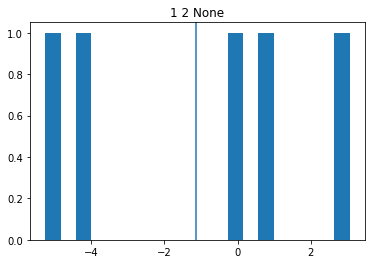

2020-09-05 10:00:00 2020-10-10 10:00:00


2021-02-28 04:00:00 2021-04-04 04:00:00


2021-08-22 22:00:00 2021-09-26 22:00:00


2022-02-14 16:00:00 2022-03-21 16:00:00


2022-08-09 10:00:00 2022-09-13 10:00:00


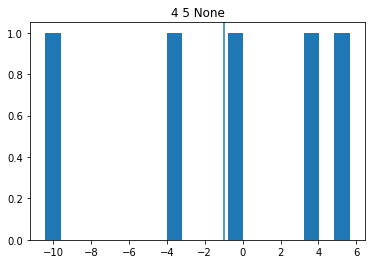

In [57]:
# for offsets in [[1,2], [2,3], [4,5], [8,9], [16,17], [32,33]]:
for offsets in [[1,2], [4,5]]: #, [8,9], [16,17], [32,33]]:
    show_expectation(offsets[0], offsets[1], None, num_test=5)

In [ ]:
# for offsets in [[1,2], [2,3], [4,5], [8,9], [16,17], [32,33]]:
for offsets in [[1,2], [4,5]]: #, [8,9], [16,17], [32,33]]:
    show_expectation(offsets[0], offsets[1], None, num_test=5)

In [55]:
# for offsets in [[1,2], [2,3], [4,5], [8,9], [16,17], [32,33]]:
for offsets in [[1,2], [4,5]]: #, [8,9], [16,17], [32,33]]:
    show_expectation(offsets[0], offsets[1], None, num_test=5)

2020-09-05 10:00:00 2020-10-10 10:00:00


2021-05-04 16:00:00 2021-06-08 16:00:00


2021-12-31 22:00:00 2022-02-04 22:00:00


KeyboardInterrupt: 

In [52]:
start = datetime(2023,4,28,10,0)
end = datetime(2023,6,2,10,0)
tsla = qbw.get_tsla(start=start, end=end)

In [51]:
tsla

,open,high,low,close,volume
time,,,,,


In [11]:
from utils import pretty_strat_df
pretty_strat_df(ic)

,underlying open,underlying close,strategy open,strategy close,hourly profit,date,dte,new option,early stop,stop loss,...,prev strat end,sell call 15 0 exp,buy call 16 0 exp,sell put -15 0 exp,buy put -16 0 exp,sell call 15 0 strike,buy call 16 0 strike,sell put -15 0 strike,buy put -16 0 strike,running profit
0,304.75,307.99,0.00,0.00,-0.00,2022-08-03 13:00:00,2.12,True,loss,0.002687,...,0.0,2022-08-05 00:00:00,2022-08-05 00:00:00,2022-08-05 00:00:00,2022-08-05 00:00:00,351.0,357.0,261.0,255.0,-0.00
1,307.94,307.45,0.00,0.00,-0.00,2022-08-03 14:00:00,2.08,True,False,0.001269,...,-0.0,2022-08-05 00:00:00,2022-08-05 00:00:00,2022-08-05 00:00:00,2022-08-05 00:00:00,357.0,363.0,261.0,255.0,-0.01
2,307.47,307.98,0.00,0.00,0.00,2022-08-03 15:00:00,2.04,False,False,0.001269,...,0.0,NaN,NaN,NaN,NaN,357.0,363.0,261.0,255.0,-0.01
3,307.99,307.40,0.00,0.00,0.00,2022-08-03 16:00:00,2.00,False,False,0.001269,...,0.0,NaN,NaN,NaN,NaN,357.0,363.0,261.0,255.0,-0.01
4,311.24,311.54,0.00,0.00,0.00,2022-08-04 10:00:00,1.25,False,False,0.001269,...,0.0,NaN,NaN,NaN,NaN,357.0,363.0,261.0,255.0,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,293.68,291.00,0.02,0.03,-0.01,2022-09-13 12:00:00,3.17,False,False,0.037472,...,0.0,NaN,NaN,NaN,NaN,353.0,359.0,257.0,251.0,-0.55
196,291.00,292.30,0.03,0.02,0.01,2022-09-13 13:00:00,3.12,False,False,0.037472,...,0.0,NaN,NaN,NaN,NaN,353.0,359.0,257.0,251.0,-0.54
197,292.27,294.83,0.02,0.01,0.01,2022-09-13 14:00:00,3.08,False,False,0.037472,...,0.0,NaN,NaN,NaN,NaN,353.0,359.0,257.0,251.0,-0.53
198,294.83,294.10,0.01,0.01,-0.00,2022-09-13 15:00:00,3.04,False,False,0.037472,...,0.0,NaN,NaN,NaN,NaN,353.0,359.0,257.0,251.0,-0.53


In [12]:
np.where(ic['close_previous'])

(array([  1,  19,  24,  54,  56,  57, 128, 161, 172, 173, 174, 187]),)

In [13]:
np.where(ic['early_stop'])

(array([  0,  18,  23,  53,  55,  56, 127, 160, 171, 172, 173, 186]),)

In [14]:
ic = IC_sim(stop_loss=50)

0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.000775826972230618 0.000775826972230618 open
0.00016456745367057304 0.00016456745367057304 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.000775826972230618 0.000775826972230618 open
0.00016456745367057304 0.00016456745367057304 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.000775826972230618 0.000775826972230618 open
0.00016456745367057304 0.00016456745367057304 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.000775826972230618 0.000775826972230618 open
0.00016456745367057304 0.00016456745367057304 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.000775826972230618 0.00077582697

In [15]:
ic = IC_sim(stop_loss=200)

0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.003299857698550124 0.003299857698550124 open
0.0

In [16]:
pretty_strat_df(ic.loc[np.where(ic['early_stop'])])

,underlying open,underlying close,strategy open,strategy close,hourly profit,date,dte,new option,early stop,stop loss,...,prev strat end,sell call 15 0 exp,buy call 16 0 exp,sell put -15 0 exp,buy put -16 0 exp,sell call 15 0 strike,buy call 16 0 strike,sell put -15 0 strike,buy put -16 0 strike,running profit


In [14]:
ic = IC_sim(stop_loss=100)

In [15]:
ic = IC_sim(stop_loss=50)

In [16]:
ic = IC_sim(stop_loss=None, stop_gain=50)

In [17]:
ic = IC_sim(stop_loss=None, stop_gain=None)

In [17]:
def IC_sim(nbars=200, stop_loss=20, stop_gain=None):
    tsla = qbw.get_tsla(nbars)
    legs = [
        LegMeta(trans='sell', contract='call', strike_offset= 15, exp_offset= 0),
        LegMeta(trans='buy',  contract='call', strike_offset= 16, exp_offset= 0),
        LegMeta(trans='sell', contract='put', strike_offset= -15, exp_offset= 0),
        LegMeta(trans='buy',  contract='put', strike_offset= -16, exp_offset= 0),
    ]  
    strat = StrategyBase(qbw=qbw, legs=legs, stop_loss=stop_loss, stop_gain=stop_gain, force_strike_diff=True)
    ic = measure_period_profit(tsla,  
        strat,
        expiration='week',
        update_freq='candle', 
        combine_legs=False)
    plots.plot_candles_and_profit(ic, lines=[f'{l.name}_strike' for l in strat.legs])
    plots.plot_candles_and_profit(
        ic, lines=[f'{l.name}_strike' for l in strat.legs if 'sell' == l.trans], 
        metrics=['strategy_close', 'stop_loss', 'stop_gain']
    )
    return ic

In [18]:
ic = IC_sim(stop_loss=None, stop_gain=None)

0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.003299857698550124 0.003299857698550124 open
0.000775826972230618 0.000775826972230618 open
0.0007390817596976407 0.0007390817596976407 open
8.11408067646624e-05 8.11408067646624e-05 open
0.003299857698550124 0.003299857698550124 open
0.0

In [19]:
ic = IC_sim(stop_loss=None, stop_gain=None)

In [20]:
np.mean([20, 0.18, 0.1])

6.760000000000001

In [21]:
np.median([20, 0.18, 0.1])

0.18